<a href="https://colab.research.google.com/github/Matt-Ralph-Lee/machine-learning/blob/main/tensorflow/tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow
Image classification using Tensorflow. Implemented ResNet from scratch.

## Import

In [ ]:
import tensorflow as tf
import tensorflow.keras as kl
print("TensorFlow version:", tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import Model

from tqdm.auto import tqdm
from typing import Dict, List
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer

TensorFlow version: 2.15.0


## Load and Format Data

In [ ]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train.shape, y_train.shape, x_test.shape, y_test.shape

170498071/170498071 [==============================] - 2s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(256)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## Visualize Data

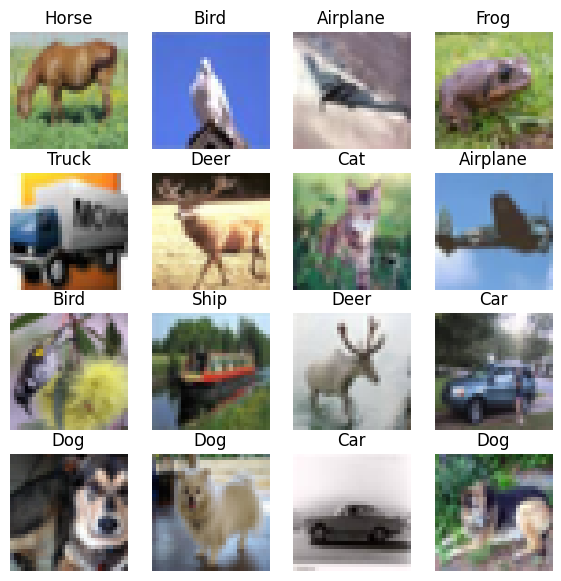

In [ ]:
class_names = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
rng = np.random.default_rng()

fig = plt.figure(figsize=(7, 7))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = rng.integers(len(x_train))
  img = x_train[random_idx]
  label = class_names[y_train[random_idx].item()]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img)
  plt.title(label)
  plt.axis(False)

## Model Definition

### Single Block

In [ ]:
class Block(Model):
  def __init__(self, in_channel, out_channel, down_sample=False):
    super().__init__()
    self.act = layers.ReLU()

    if down_sample:
      stride = 2
      self.downsample = kl.Sequential([
          layers.Conv2D(out_channel, kernel_size=1, strides=(2, 2), padding='same', use_bias=False),
          layers.BatchNormalization()
      ])
    else:
      stride = 1
      self.downsample = kl.Sequential([
          layers.Conv2D(out_channel, kernel_size=1, strides=(1, 1), padding='same', use_bias=False),
          layers.BatchNormalization()
      ])

    self.conv1 = layers.Conv2D(in_channel, kernel_size=3, strides=(stride, stride), padding='same', use_bias=False)
    self.bn1 = layers.BatchNormalization()

    self.conv2 = layers.Conv2D(out_channel, kernel_size=3, strides=(1, 1), padding='same', use_bias=False)
    self.bn2 = layers.BatchNormalization()

    self.add = layers.Add()

    self.dropout = layers.Dropout(0.3)

  def call(self, x):
    identity = x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.act(x)

    x = self.dropout(x)

    x = self.conv2(x)
    x = self.bn2(x)

    x = self.dropout(x)

    if self.downsample is not None:
      identity = self.downsample(identity)

    x = self.dropout(x)

    x = self.add([identity, x])

    x = self.act(x)

    return x

### Whole Model

In [ ]:
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = layers.Conv2D(64, kernel_size=4, strides=(1, 1), padding='same', use_bias=False)
    self.bn = layers.BatchNormalization()
    self.act = layers.ReLU()
    self.pool1 = layers.MaxPool2D(pool_size=(3, 3),  strides=(2, 2), padding='same')
    self.pool2 = layers.GlobalAveragePooling2D()
    self.fc = layers.Dense(10, activation='softmax')

    self.layer1 = [
        Block(64, 64) for _ in range(3)
    ]

    self.layer2 = [
        Block(128, 128, False)
    ]
    for i in range(4):
      self.layer2.append(Block(128, 128))

    self.layer3 = [
        Block(128, 256, True)
    ]
    for _ in range(5):
      self.layer3.append(Block(256, 256))


    self.layer4 = [
        Block(256, 512, False)
    ]
    for _ in range(3):
      self.layer4.append(Block(512, 512))

  def call(self, x):
    x = self.conv1(x)
    x = self.bn(x)
    x = self.act(x)

    x = self.pool1(x)

    for i in range(len(self.layer1)):
      x = self.layer1[i](x)

    for i in range(len(self.layer2)):
      x = self.layer2[i](x)

    for i in range(len(self.layer3)):
      x = self.layer3[i](x)

    for i in range(len(self.layer4)):
      x = self.layer4[i](x)

    x = self.pool2(x)

    x = self.fc(x)

    return x


## Preparation for Training

In [ ]:
model = MyModel()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
result = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
}

## Training

In [ ]:
EPOCHS = 50

start_time = timer()

for epoch in tqdm(range(EPOCHS)):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )
  result["train_loss"].append(train_loss.result())
  result["train_acc"].append(train_accuracy.result())
  result["test_loss"].append(test_loss.result())
  result["test_acc"].append(test_accuracy.result())

  if epoch >= 40:
    optimizer.learning_rate = 0.001
  elif epoch >= 25:
    optimizer.learning_rate = 0.01

end_time = timer()
print(f"Total Training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 2.398360013961792, Accuracy: 10.394000053405762, Test Loss: 2.461207389831543, Test Accuracy: 13.380000114440918
Epoch 2, Loss: 2.1933977603912354, Accuracy: 15.173999786376953, Test Loss: 3.0116496086120605, Test Accuracy: 10.050000190734863
Epoch 3, Loss: 1.8229882717132568, Accuracy: 29.92799949645996, Test Loss: 2.021599292755127, Test Accuracy: 23.43000030517578
Epoch 4, Loss: 1.5672129392623901, Accuracy: 41.24800109863281, Test Loss: 1.9410511255264282, Test Accuracy: 39.13999938964844
Epoch 5, Loss: 1.3986467123031616, Accuracy: 48.36000061035156, Test Loss: 2.209419012069702, Test Accuracy: 36.81999969482422
Epoch 6, Loss: 1.2622789144515991, Accuracy: 53.986000061035156, Test Loss: 1.670840859413147, Test Accuracy: 46.48999786376953
Epoch 7, Loss: 1.1448086500167847, Accuracy: 58.512001037597656, Test Loss: 1.6540597677230835, Test Accuracy: 49.54999923706055
Epoch 8, Loss: 1.0457780361175537, Accuracy: 62.35200119018555, Test Loss: 1.6367987394332886, Test Acc

# Result

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(9, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

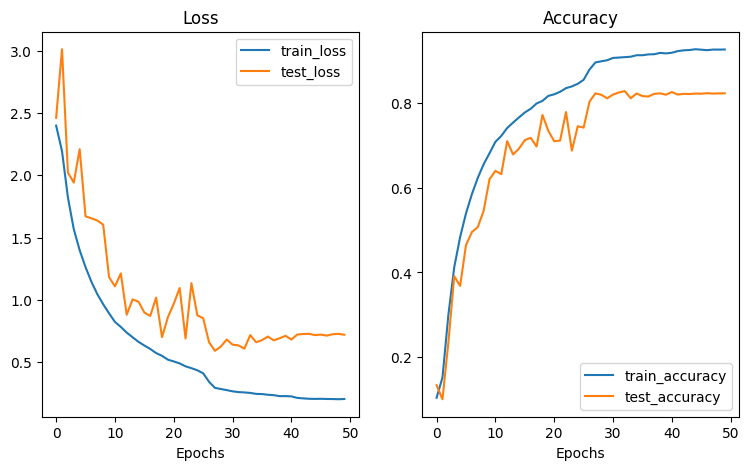

In [ ]:
plot_loss_curves(result)

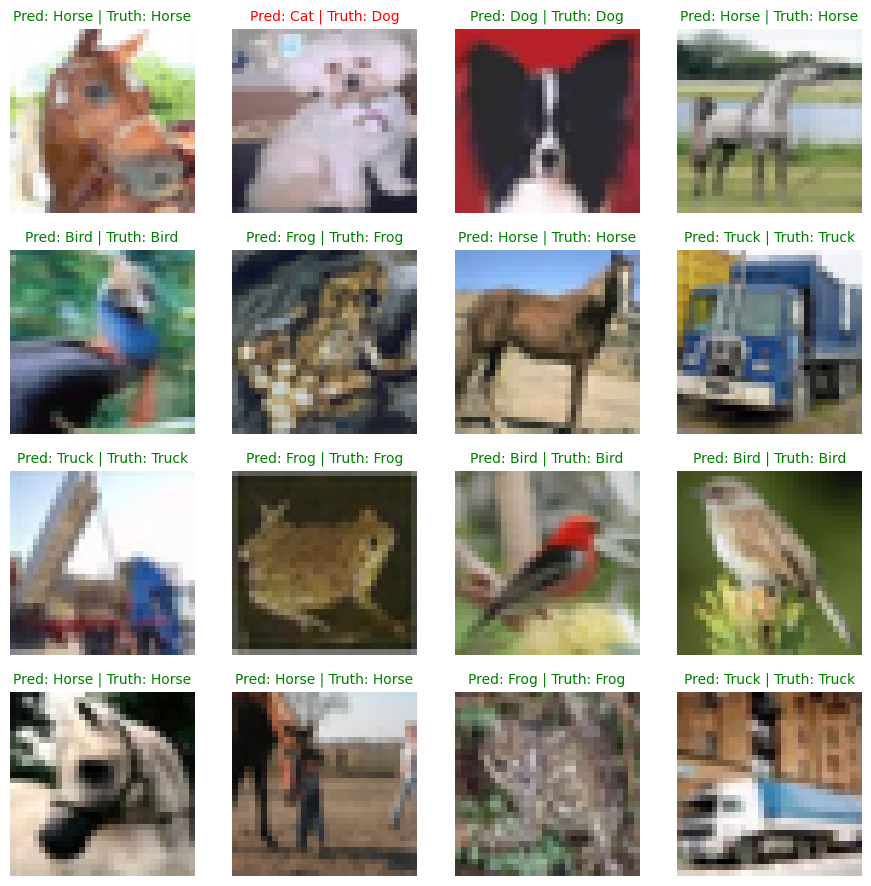

In [ ]:
fig = plt.figure(figsize=(11, 11))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = rng.integers(len(x_test))
  img = x_test[random_idx]
  label = class_names[y_test[random_idx].item()]
  probability = model(img[np.newaxis, :, :, :])
  pred = np.argmax(probability)
  fig.add_subplot(rows, cols, i)
  plt.imshow(img)
  color = "green" if class_names[pred] == label else "red"
  plt.title(label)
  plt.title(f"Pred: {class_names[pred]} | Truth: {label}", fontsize=10, color=color)
  plt.axis(False)